In [1]:
import json
import multiprocessing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import stellargraph as sg
from IPython.display import HTML, display
from sklearn import feature_extraction, model_selection, preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from stellargraph import StellarGraph, datasets
from stellargraph.layer import HinSAGE, link_regression
from stellargraph.mapper import HinSAGELinkGenerator
from sweettvmovie.utils.fe import make_movie_features, make_user_features
from sweettvmovie.utils.metrics import construct_true_labels, mapk
from sweettvmovie.utils.preprocessing import process_data
from sweettvmovie.utils.validation import (create_interaction_matrix,
                                           finetune_suggestions)
from tensorflow.keras import Model, losses, metrics, optimizers

%matplotlib inline

In [2]:
# check GPU support
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Baseline is based on [this StellarGraph example](https://stellargraph.readthedocs.io/en/v1.2.1/demos/link-prediction/hinsage-link-prediction.html?highlight=movielens)

## Preprocess data

In [3]:
use_cached = False  # set to False to run preprocessing, use cached results otherwise
filter_infrequent = 50
filter_type = 'users'
# filter_infrequent = 0

if use_cached:
    views, movies, submission, cat_dict = load_processed_data()
else:
    views, movies, submission, cat_dict = process_data(
        return_data=True, 
        drop_unknown_movies=True,
        filter_infrequent=filter_infrequent,
        filter_type=filter_type,
    )

2020-11-16 22:28:13,223 | INFO : Working with `submission` file...
2020-11-16 22:28:13,227 | INFO : df shape: (1695, 2)
2020-11-16 22:28:13,229 | INFO : Users found in test: 1695
2020-11-16 22:28:13,229 | INFO : Working with `views` file...
2020-11-16 22:28:13,551 | INFO : df shape: (346408, 8)
2020-11-16 22:28:13,596 | INFO : Users found in train: 2055
2020-11-16 22:28:13,597 | INFO : Test users found in train: 1695/1695
2020-11-16 22:28:13,605 | INFO : episodic movies views share, %: 14.9288
2020-11-16 22:28:13,706 | INFO : Movie db shape: (19265, 15)
2020-11-16 22:28:13,725 | INFO : NaN count:
year             0.000000
title            0.102933
description      0.335323
genres           0.110044
director         0.084402
actors           0.108695
writers          0.470023
music            0.587750
art              0.609136
producer         0.655178
imdb_id          0.210122
tmdb_id          0.278432
imdb_rating      0.254555
tmdb_rating      0.292032
available_now    0.000000
dtype:

## Prepare Graph data

### get user, movie features

In [4]:
views['available_now'] = views.user_id.map(movies['available_now']).fillna(False).astype(bool)
views['rating'] = 1.
views.head()

# imitate train/test split
test_range = (views.ts.max() - np.timedelta64(2, 'M'), views.ts.max())

test_df_idx = (
    (views.ts >= test_range[0])
    & (views.ts <= test_range[1])
).values

train_df_idx = ~test_df_idx

print(views[train_df_idx].shape, views[test_df_idx].shape)
assert (train_df_idx + test_df_idx).sum() == len(views)

(223961, 10) (39484, 10)


In [5]:
user_features = make_user_features(
    df_views=views[train_df_idx].copy(),
    df_movies=movies,
    cat_dict=cat_dict,
).fillna(0.)

movie_features = make_movie_features(
    df_views=views[train_df_idx].copy(),
    df_movies=movies,
    cat_dict=cat_dict,
).fillna(0.)

# scale features
ss_uf, ss_mf = StandardScaler(), StandardScaler()
user_features_scaled = pd.DataFrame(ss_uf.fit_transform(user_features), index=user_features.index)
movie_features_scaled = pd.DataFrame(ss_uf.fit_transform(movie_features), index=movie_features.index)

In [6]:
# rename ids, as hinsage doesn't allow nodes of different types to have id collisions 
# (like movie_id=2 and user_id=2)

user_features.index = 'u_' + user_features.index.astype(str)
user_features_scaled.index = 'u_' + user_features_scaled.index.astype(str)

movie_features.index = 'm_' + movie_features.index.astype(str)
movie_features_scaled.index = 'm_' + movie_features_scaled.index.astype(str)


views['movie_id'] = 'm_' + views['movie_id'].astype(str)
views['user_id'] = 'u_' + views['user_id'].astype(str)

print(user_features_scaled.index[:4])
print(movie_features_scaled.index[:4])

views.head()

Index(['u_1', 'u_2', 'u_3', 'u_4'], dtype='object', name='user_id')
Index(['m_1', 'm_2', 'm_3', 'm_4'], dtype='object', name='movie_id')


ts user_id movie_id  episode_id  view_month  view_year  \
2 2019-10-01 00:01:57   u_222   m_9936           0          10       2019   
3 2019-10-01 00:02:41  u_1851  m_13294           0          10       2019   
4 2019-10-01 00:03:17  u_1693   m_9839           0          10       2019   
5 2019-10-01 00:03:48   u_798  m_12420           0          10       2019   
6 2019-10-01 00:05:13  u_1714  m_13196       81580          10       2019   

   view_weekday  view_monthday  available_now  rating  
2             1              1          False     1.0  
3             1              1          False     1.0  
4             1              1          False     1.0  
5             1              1          False     1.0  
6             1              1          False     1.0

### Prepare "ratings"

In [7]:
ratings_train = views[train_df_idx]\
.groupby(['user_id', 'movie_id'])['rating'].sum().apply(np.log1p).reset_index()
ratings_test = views[test_df_idx]\
.groupby(['user_id', 'movie_id'])['rating'].sum().apply(np.log1p).reset_index()

print(ratings_train.shape, ratings_test.shape)
# filter ratings_test to have only (user, movie pairs not present in ratings_train)
ratings_test = ratings_test.loc[
    ~ratings_test.set_index(['user_id', 'movie_id']).index.isin(
        ratings_train.set_index(['user_id', 'movie_id']).index
    )
]
print(ratings_train.shape, ratings_test.shape)

print(ratings_train.rating.mean(), ratings_test.rating.mean())

ratings_test.head()

(162886, 3) (30872, 3)
(162886, 3) (30409, 3)
0.7534441275085247 0.7276575183417114


user_id movie_id    rating
0     u_1  m_13879  0.693147
1     u_1   m_6599  0.693147
2     u_1   m_8014  0.693147
3    u_10  m_10027  0.693147
4    u_10  m_11851  0.693147

### Create heterogenous graph

In [8]:
# rating edges
cols = ['user_id', 'movie_id']
rating_edges = pd.concat(
    [
        ratings_train[cols],
        ratings_test[cols],
    ],
    ignore_index=True, 
    sort=False
)
rating_edges.columns = ['source', 'target']

print(rating_edges.shape)

rating_edges.head()

(193295, 2)


source   target
0    u_1  m_10736
1    u_1  m_11292
2    u_1  m_11481
3    u_1  m_13329
4    u_1  m_13488

In [9]:
G = StellarGraph(
    nodes={
        "user": user_features_scaled, 
        "movie": movie_features_scaled,
    },
    edges={
        'rating': rating_edges,
    },
)

print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 18245, Edges: 193295

 Node types:
  movie: [16190]
    Features: float32 vector, length 37
    Edge types: movie-rating->user
  user: [2055]
    Features: float32 vector, length 33
    Edge types: user-rating->movie

 Edge types:
    movie-rating->user: [193295]
        Weights: all 1 (default)
        Features: none


In [10]:
# define train/test edges
# edgelist_train = list(ratings_train[["user_id", "movie_id"]].itertuples(index=False))
# edgelist_test = list(ratings_test[["user_id", "movie_id"]].itertuples(index=False))

edgelist_train = list(ratings_train[["user_id", "movie_id"]].values.tolist())
edgelist_test = list(ratings_test[["user_id", "movie_id"]].values.tolist())

labels_train = ratings_train["rating"].values
labels_test = ratings_test["rating"].values

In [11]:
# Specify the sizes of 1- and 2-hop neighbour samples for HinSAGE:
# Note that the length of num_samples list defines the number of layers/iterations in the HinSAGE model.

# hinsage params
batch_size = 64
epochs = 10

num_samples = [8, 4]

generator = HinSAGELinkGenerator(
    G=G,
    batch_size=batch_size,
    num_samples=num_samples,
    head_node_types=["user", "movie"],
    seed=42,
)

train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
test_gen = generator.flow(edgelist_test, labels_test)

In [12]:
# check generator's schema
print(generator.schema.schema)

# check x-hop (1-2-hops in this baseline) node transition types
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

{'user': [EdgeType(n1='user', rel='rating', n2='movie')], 'movie': [EdgeType(n1='movie', rel='rating', n2='user')]}


[('user', [2]),
 ('movie', [3]),
 ('movie', [4]),
 ('user', [5]),
 ('user', []),
 ('movie', [])]

In [13]:
hinsage_layer_sizes = [32, 16]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, 
    generator=generator, 
    bias=True, 
    dropout=0.05,
)

# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.in_out_tensors()

# input tensors
x_inp

[<tf.Tensor 'input_1:0' shape=(None, 1, 33) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(None, 1, 37) dtype=float32>,
 <tf.Tensor 'input_3:0' shape=(None, 8, 37) dtype=float32>,
 <tf.Tensor 'input_4:0' shape=(None, 8, 33) dtype=float32>,
 <tf.Tensor 'input_5:0' shape=(None, 32, 33) dtype=float32>,
 <tf.Tensor 'input_6:0' shape=(None, 32, 37) dtype=float32>]

In [14]:
# output tensors
x_out

[<tf.Tensor 'lambda/Identity:0' shape=(None, 16) dtype=float32>,
 <tf.Tensor 'lambda_1/Identity:0' shape=(None, 16) dtype=float32>]

Add the final estimator layer for predicting the ratings. The edge_embedding_method argument specifies the way in which node representations (node embeddings) are combined into link representations (recall that links represent user-movie ratings, and are thus pairs of (user, movie) nodes). In this example, we will use concat, i.e., node embeddings are concatenated to get link embeddings.

In [15]:
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import mae


def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


# Final estimator layer
score_prediction = link_regression(edge_embedding_method="concat")(x_out)


model = Model(
    inputs=x_inp,
    outputs=score_prediction
)

model.compile(
    optimizer=optimizers.Adam(lr=0.0001),
#         loss=losses.Huber(),
    loss=losses.mean_squared_error,
    metrics=[mae],
)

# model.compile(
#     optimizer=optimizers.Adam(lr=1e-2),
#     loss=losses.mean_squared_error,
#     metrics=[root_mean_square_error, metrics.mae],
# )

# check model's structure
model.summary()

link_regression: using 'concat' method to combine node embeddings into edge embeddings
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8, 37)]      0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 32, 33)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32, 37)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1, 33)]      0                                            
_______

Evaluate the fresh (untrained) model on the test set (for reference):

In [16]:
# Specify the number of workers to use for model training
from os import cpu_count

num_workers = max(cpu_count(), 1)


test_metrics = model.evaluate(
    x=test_gen,
    verbose=1,
    use_multiprocessing=False,
    workers=num_workers,
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

476/476 [==============================] - 9s 18ms/step - loss: 0.3891 - mean_absolute_error: 0.5605
Untrained model's Test Evaluation:
	loss: 0.3891
	mean_absolute_error: 0.5605


Epoch 1/10
2546/2546 [==============================] - 61s 24ms/step - loss: 0.0885 - mean_absolute_error: 0.1429 - val_loss: 0.0350 - val_mean_absolute_error: 0.0818
Epoch 2/10
2546/2546 [==============================] - 61s 24ms/step - loss: 0.0610 - mean_absolute_error: 0.1024 - val_loss: 0.0306 - val_mean_absolute_error: 0.0610
Epoch 3/10
2546/2546 [==============================] - 62s 24ms/step - loss: 0.0580 - mean_absolute_error: 0.0881 - val_loss: 0.0300 - val_mean_absolute_error: 0.0577
Epoch 4/10
2546/2546 [==============================] - 62s 24ms/step - loss: 0.0566 - mean_absolute_error: 0.0827 - val_loss: 0.0297 - val_mean_absolute_error: 0.0534
Epoch 5/10
2546/2546 [==============================] - 59s 23ms/step - loss: 0.0557 - mean_absolute_error: 0.0799 - val_loss: 0.0295 - val_mean_absolute_error: 0.0532
Epoch 6/10
2546/2546 [==============================] - 61s 24ms/step - loss: 0.0550 - mean_absolute_error: 0.0778 - val_loss: 0.0298 - val_mean_absolute_error:

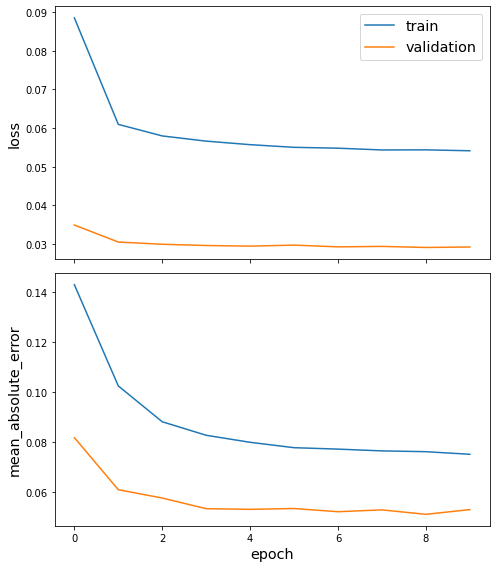

In [17]:
# train model
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

# plot training loss history
sg.utils.plot_history(history)

In [18]:
# check test metrics of 'trained' model
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

476/476 [==============================] - 9s 19ms/step - loss: 0.0291 - mean_absolute_error: 0.0529
Test Evaluation:
	loss: 0.0291
	mean_absolute_error: 0.0529


In [19]:
top_N_movies = 200

top_movies = movie_features[
    movie_features.available_now # top-available
#     (movie_features.available_now + 1).astype(bool) # top-all
].sort_values(
    by='unique_users_watches_log', ascending=False
)[:top_N_movies].index.values

big_index = pd.MultiIndex.from_product(
    iterables=(
        ratings_test['user_id'].unique(),
        top_movies, # for speed
    ),
    names=('user_id', 'movie_id')
)

print(top_movies[:5])
print(big_index.shape)

['m_15124' 'm_15078' 'm_15040' 'm_14952' 'm_6595']
(350600,)


In [20]:
from tqdm.auto import tqdm

chunk_size = 1024
N = len(big_index)
n_chunks = int(np.ceil(N / chunk_size))

predictions = np.zeros(shape=(N, 1), dtype=np.float32)

for i in tqdm(range(n_chunks)):
    
    ratings_to_predict = generator.flow(
        link_ids=big_index[i*chunk_size:(i+1)*chunk_size],
    )

    predictions[i*chunk_size:(i+1)*chunk_size] = model.predict(ratings_to_predict)

In [21]:
K = 5

df_pred = pd.DataFrame(predictions, index=big_index).rename(columns={0: 'predictions'}).reset_index()
labels_pred = df_pred.sort_values(
    by=['user_id', 'predictions'], 
    ascending=[True, False]
).groupby(['user_id'])['movie_id'].apply(
    lambda x: [int(i.strip('m_')) for i in x[:K]]
#     lambda x: list(x[:K])
)

labels_pred.head()

user_id
u_1       [10606, 15151, 13164, 13197, 14936]
u_10      [10606, 15151, 14936, 13198, 13164]
u_100     [10606, 15151, 13198, 13197, 13164]
u_1001    [10606, 15151, 13164, 13197, 14936]
u_1002    [10606, 15151, 14936, 13164, 14675]
Name: movie_id, dtype: object

In [22]:
labels_true = construct_true_labels(
    df=views[test_df_idx],
    drop_duplicates=True,
    return_list=False
)

labels_true = {
    k:[int(i.strip('m_')) for i in v]
    for (k,v) in labels_true.items()
}

labels = pd.DataFrame(
    {
        'true': labels_true,
        'pred': labels_pred,
    }
)

# fill NA predictions
labels = labels.applymap(lambda x: x if isinstance(x, list) else list())

print(labels[labels['pred'].isnull()])

labels.head()

Empty DataFrame
Columns: [true, pred]
Index: []


true  \
u_1                     [6599, 8014, 13879]   
u_10    [11885, 15117, 14129, 15407, 15243]   
u_100                         [14337, 4427]   
u_1001   [15043, 10582, 9326, 15124, 14178]   
u_1002    [15073, 8508, 14791, 3934, 14460]   

                                       pred  
u_1     [10606, 15151, 13164, 13197, 14936]  
u_10    [10606, 15151, 14936, 13198, 13164]  
u_100   [10606, 15151, 13198, 13197, 13164]  
u_1001  [10606, 15151, 13164, 13197, 14936]  
u_1002  [10606, 15151, 14936, 13164, 14675]

In [23]:
# evaluate MAP@5

map_value = mapk(
    actual=labels['true'], 
    predicted=labels['pred'], 
    k=K,
)

print (f'MAP-{K}  HinSAGE    : {map_value:.6f}')

MAP-5  HinSAGE    : 0.011473


In [24]:
# remove prefixes, restore int ids
user_features.index = user_features.index.str.strip('u_').astype(int)
user_features_scaled.index = user_features_scaled.index.str.strip('u_').astype(int)

movie_features.index = movie_features.index.str.strip('m_').astype(int)
movie_features_scaled.index = movie_features_scaled.index.str.strip('m_').astype(int)

views['movie_id'] = views['movie_id'].str.strip('m_').astype(int)
views['user_id'] = views['user_id'].str.strip('u_').astype(int)

labels.index = labels.index.str.strip('u_').astype(int)

In [25]:
# correct predictions
tmp = pd.DataFrame(labels_pred.values.tolist(), index=labels_pred.index)
tmp.index = tmp.index.str.strip('u_').astype(int)


tmp = finetune_suggestions(
    suggestions=tmp,
    user_features=user_features,
    movie_features=movie_features,
    historical_views=views[train_df_idx],
    top_k=K,
)

stable user share  (movies), %: 0.0000
stable user share (serials), %: 3.6496
unstable user share  (movies), %: 65.5474
unstable user share (serials), %: 0.0000
suggestions substituted, %: 69.197


In [26]:
# labels['pred_finetuned'] = [
#     v for (k,v) in dict(zip(tmp.index.values, tmp.values.astype(int).tolist())).items() 
#     if f'u_{k}' in labels.index
# ]

labels['pred_finetuned'] = tmp[tmp.index.isin(labels.index)].astype(int).values.tolist()
# labels['pred_finetuned'] = np.where(labels['pred_finetuned'])

idx_zero = labels['pred_finetuned'].apply(sum) == 0
labels.loc[idx_zero, 'pred_finetuned'] = labels.loc[idx_zero, 'pred']

In [27]:
# evaluate MAP@5

map_value_ft = mapk(
    actual=labels['true'], 
    predicted=labels['pred_finetuned'], 
    k=K,
)

print (f'MAP-{K}  HinSAGE    : {map_value_ft:.6f}')

MAP-5  HinSAGE    : 0.012598
